In this section, we will apply the MLflow concepts we have learned so far.

## Employee Attrition Detection

**Objective**  

Predict if an employee is likely to quit and identify the factors responsible - to allow HR to intervene on time and remedy the situation to prevent attrition.  While some level of attrition in a company is inevitable, minimizing it and being prepared for the cases that cannot be helped will significantly help improve the operations of most businesses.

**Data**  

The data set presents an employee survey from IBM, indicating if there is attrition or not. The data set contains approximately 1500 entries. Given the limited size of the data set, the model should only be expected to provide modest improvement in indentification of attrition vs a random allocation of probability of attrition.

### Import libraries

MLflow supports wide variety of ML frameworks. For this example we will use the simple and popular `sklearn` library for training a model. Additionally, for clarity, we have abstracted the steps for ML classification into a `kainos_sklearn` package.

In [79]:
import warnings

import mlflow
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)

from kainos_sklearn.classifier import *

warnings.filterwarnings(action="ignore")

### Load data

The hr attrition data is available in csv format, so we can easily load it into a pandas dataframe.

In [80]:
data = load_csv("./data/hr_attrition.csv")

n_rows, n_cols = data.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

Rows: 1470, Columns: 35


### Data Config

The outcome of machine learning algorithm also depends on the tuning we apply to the data, hence it's important to keep a track of those too.

In [81]:
drop_cols = [
    "EmployeeNumber",
    "EmployeeCount",
    "Over18",
    "StandardHours",
    "Attrition",
]

label_col = "Attrition"

test_size = 0.2
category_threshold = 8
feature_encoder = OneHotEncoder
feature_scaler = StandardScaler

### ML Config

ML parameters are another import set of values to be tracked. Each algorithm has it's own parameters and our goal of our experiments is to find the parameters that works best for achieving our objective.

In [74]:
tracking_uri = "http://localhost:5000"
experiment_name = "attrition_rf"

# set sklearn classifer model and it's parameters
sklearn_classifier = RandomForestClassifier
model_params = dict(n_estimators=100, criterion="gini", random_state=42)

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name);

### Experiments

This is an iterative step. Here we infuse the code with MLflow to allow us to record the data/ml parameters and metrics. The idea is to set the values in previous two cells (data and ml config) and run the experiment. The process is to be repeated until desired results are achieved.

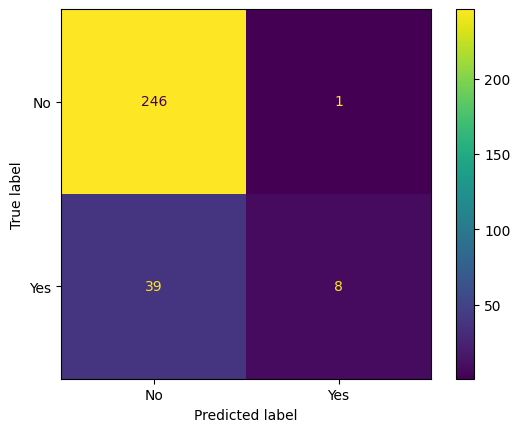

In [75]:
# | output: false

with mlflow.start_run() as run:

    # log data and ml config
    mlflow.log_param("feature_encoder", feature_encoder.__name__)
    mlflow.log_param("feature_scaler", feature_scaler.__name__)
    mlflow.log_param("sklearn_classifier", sklearn_classifier.__name__)
    mlflow.log_param("test_size", test_size)
    mlflow.log_params(model_params)

    # split data
    train_X, train_y, test_X, test_y = split_data(
        data, drop_cols=drop_cols, label_col=label_col, test_size=test_size
    )

    # train model
    model, labels_encoder = train(
        train_X,
        train_y,
        feature_encoder,
        feature_scaler,
        sklearn_classifier,
        category_threshold,
    )

    # log model
    signature = infer_signature(train_X, model.predict(train_X.sample(100)))
    mlflow.sklearn.log_model(model, "hr-attrition-model", signature=signature)

    # evaluate on test data using trained model
    accuracy, precision, recall, f1, cm, plt_cm = evaluate(
        model, labels_encoder, test_X, test_y
    )

    # log metrics
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("f1_score", f1)

    # log figure as artifact
    fig_name = "confusion-matrix.png"
    plt_cm.savefig(fig_name)
    mlflow.log_artifact(fig_name, "confusion-matrix-plot")

In [76]:
# | echo: false
model

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['BusinessTravel',
                                                   'Department', 'Education',
                                                   'EducationField',
                                                   'EnvironmentSatisfaction',
                                                   'Gender', 'JobInvolvement',
                                                   'JobLevel',
                                                   'JobSatisfaction',
                                                   'MaritalStatus', 'OverTime',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TrainingTimesLastYe...
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [77]:
# | echo: false
print(f"accuracy_score: {round(accuracy, 2)}")
print(f"precision_score: {round(precision, 2)}")
print(f"recall_score: {round(recall, 2)}")
print(f"f1_score: {round(f1, 2)}")

accuracy_score: 0.86
precision_score: 0.89
recall_score: 0.17
f1_score: 0.29


## MLflow Models

MLflow logs a standard model format for each run and makes it available to be consumed by various downstream tools - for example, real-time serving through REST API or batch inference on Apache Spark.  

> In this tutorial, we will serve our model for real-time prediction using REST API.  

Each **MLflow Model** is a directory containing arbitrary files, together with an `MLmodel` file in the root of the directory that can define multiple **flavors** that the model can be viewed in. If we look at the structure of our logged scikit-learn model, it looks as follows:

```
hr-attrition-model/
├── MLmodel
├── model.pkl
├── conda.yaml
├── python_env.yaml
└── requirements.txt
```

The `MLmodel` file stores the information about all the flavours in which the saved model is available. In our case, the file describes two flavours.

```yml
artifact_path: hr-attrition-model
flavors:
  python_function:
    env: conda.yaml
    loader_module: mlflow.sklearn
    model_path: model.pkl
    predict_fn: predict
    python_version: 3.8.13
  sklearn:
    code: null
    pickled_model: model.pkl
    serialization_format: cloudpickle
    sklearn_version: 1.1.3
mlflow_version: 1.30.0
```

This model can then be used with any tool that supports either the `sklearn` or `python_function` model flavor. For example, the mlflow models serve command can serve a model with the `python_function`:

```bash
mlflow models serve \
  -m 'runs:/cf70d23652c343e08a68cf9a88697528/hr-attrition-model' \
  --port 8123 \
  --no-conda
```

### MLflow Model Serving

The served MLflow model is available as an endpoint and can be used as follows:

In [78]:
# | output: false

import requests

api_endpoint = "http://localhost:8123/invocations"
data = test_X[0:1].to_json(orient="records")
headers = {"Content-Type": "application/json"}
response = requests.post(url=api_endpoint, data=data, headers=headers)
prediction = response.text
print(prediction)

[0]


## Excercise

- Run more experiments on the attrition data [Update the same notebook]
    - Try few more sklearn classifier models on the attrition data and see if you are able to get better f1-score
    - Check if you are able to compare results across experiments
    - Register the model that gave you the best `f1-score`
- Update your ML training code to use MLflow for tracking experiments [Create a new notebook]
    - Make this part of the `intro-to-mlflow` repository you forked on Github
    - Register the model and create multiple version
    - Serve the model using `mlflow serve` cli and send a `POST` request to the `REST API`

## Further Reading

- [Continuous Delivery for Machine Learning](https://martinfowler.com/articles/cd4ml.html)